In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
import pydot
from io import StringIO

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

In [2]:
import pydot
from IPython.display import Image
def print_tree(estimator, features, class_names=None, filled=True):
  tree = estimator
  names = features
  color = filled
  classn = class_names
  dot_data = StringIO()
  export_graphviz(estimator, out_file=dot_data,feature_names=features,class_names=classn, filled=filled)
  graph = pydot.graph_from_dot_data(dot_data.getvalue())
  return(graph)

In [3]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 305 (delta 108), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (305/305), 26.30 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [4]:
wine = pd.read_csv('ML_656/winequality-red.csv', sep = ';')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Define high quality wine

In [5]:
wine['quality'] = wine['quality'] > 6
wine['quality'].describe()

count      1599
unique        2
top       False
freq       1382
Name: quality, dtype: object

In [6]:
np.random.seed(42)
train, test = train_test_split(wine, test_size = 0.5)
test, val = train_test_split(test, test_size = 0.5)
X_train = train.drop(columns = ['quality'])
y_train = train['quality']
X_val = val.drop(columns = ['quality'])
y_val = val['quality'].values
X_test = test.drop(columns = ['quality'])
y_test = test['quality'].values

###Random forest


In [30]:
rf = RandomForestRegressor(max_features=20, n_estimators=500, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=20, n_estimators=500, random_state=1)

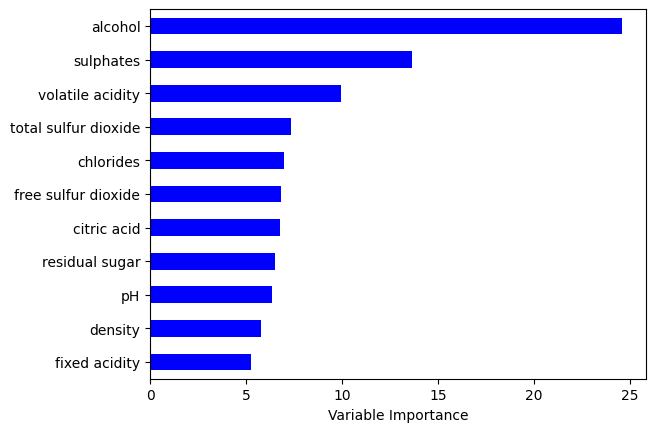

In [31]:
Importance_ = pd.DataFrame({'Importance':rf.feature_importances_*100}, index=X_train.columns)
Importance = Importance_.sort_values('Importance', axis=0, ascending=False)[0:20]
Importance.plot(kind='barh', color='b', ).invert_yaxis()
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

Predict the outcome

In [34]:
random_forest_preds = rf.predict(X_test)
random_forest_preds_labels = random_forest_preds > 0.5

Confusion matrix

In [35]:
table1 = pd.DataFrame({'Quality':test.quality,'Predicted':random_forest_preds_labels})
table1.groupby(['Quality','Predicted']).size().unstack('Quality')

Quality,False,True
Predicted,,
False,329,30
True,18,23


In [37]:
# TPR
23/(18+23)

0.5609756097560976

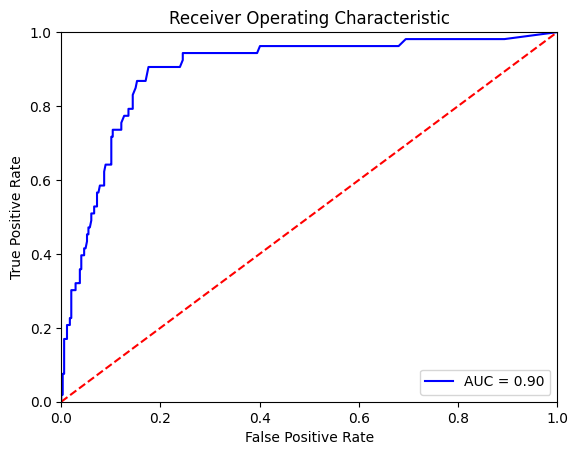

In [36]:
fpr, tpr, threshold = roc_curve(y_test, random_forest_preds)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest outperforms a single decision tree with 12 nodes, which achieves an AUC of 0.81. This indicates that by leveraging aggregation and randomization, Random Forest can enhance its classification capabilities. Furthermore, the true positive rate increases from 0.47 to 0.56, demonstrating the model's improved ability to classify high-quality wine.

When compared to the logistic model from module 2, both models have the same AUC, which is 0.9. In this scenario, I would choose Random Forest due to its higher True Positive Rate (TPR) of 0.56, in contrast to the logistic model's TPR of 0.27.

###Boosting

In [27]:
boost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.01,random_state=1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=5000, random_state=1)

alcohol                 26.060937
sulphates               13.607104
volatile acidity        10.424816
chlorides                8.029763
total sulfur dioxide     7.989002
citric acid              7.461006
density                  5.895707
fixed acidity            5.715360
pH                       5.287419
free sulfur dioxide      4.941728
residual sugar           4.587159
dtype: float64


Text(0.5, 0, 'Variable Importance')

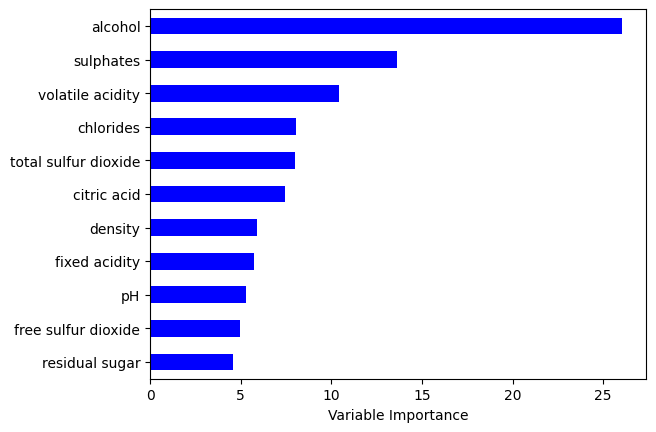

In [28]:
feature_importance = boost.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False, inplace=False)
rel_imp = rel_imp[0:20]
print(rel_imp)
rel_imp.plot(kind='barh', color='b', ).invert_yaxis()
plt.xlabel('Variable Importance')

In [49]:
pred_boost = boost.predict(X_test)
pred_boost_label = pred_boost > 0.5

In [48]:
table2 = pd.DataFrame({'Quality':test.quality,'Predicted':pred_boost_label})
table1.groupby(['Quality','Predicted']).size().unstack('Quality')

Quality,False,True
Predicted,,
False,329,30
True,18,23


Text(0.5, 0, 'False Positive Rate')

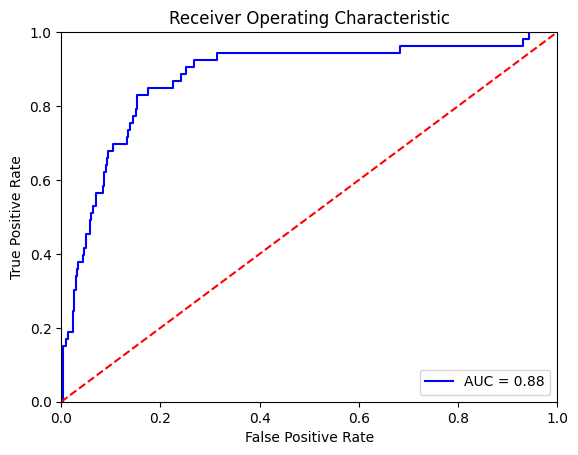

In [46]:
fpr, tpr, threshold = roc_curve(y_test, pred_boost)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Overall, both the boosting tree and the random forest outperform a single tree, exhibiting increased AUC.  

Compared to the logistic model in module 2, we notice a slightly smaller AUC in the boosting model. However, this model excels in classifying high-quality wine when the threshold is set at 0.5